## Goal: To subtract rasters, but have a means to clip to different extent if the shapes are not the same size

In [4]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import fiona
from shapely.geometry import mapping, Polygon
import os
from scipy import sparse
%matplotlib inline

In [7]:
#change these variables dependent on wshed and phase
single_phase = "P05"
#change to no if only doing a single file
multiple = "no"
wshed = "VAN"

#file directories for metrovan, would be best to put all in a dictionary
phase_list = ["P01","P02", "P03", "P04", "P05"]
DEM_list = {"VAN" : {"BE" : r"H:\Metro-Van\2021\DEM\Baseline_Master_Dataset_WGS84\VAN_snowfree_merged_wgs84_utm10_itrf08_epoch2002_dz20cm_1mDEM.tif",
                     "STM" : r"H:\Metro-Van\2021\DEM\Coreg_STM\VAN_" + single_phase + "_coregSTM.tif"},
           "EGM" : {"BE" : r"H:\Englishman\2021\DEMs\Baseline Master Dataset - WGS84\00_3012_00_bare_earth_snowfree_wgs84_ellips_utmz10_1mDEM.tif",
                   "STM" : r"H:\Englishman\2021\DEMs\co-registered_STM\EGM_" + single_phase + "_coregSTM.tif"}}
outdirectory = {"VAN" : r"H:\\Metro-Van\\2021\GIS\snow_depth_rasters", 
                "EGM" : r"H:\Englishman\2021\GIS\sd_rasters"
               }

In [8]:
# BE and STM are the two rasters which will be calculating with
BE = rio.open(DEM_list[wshed]["BE"])
BE_meta = BE.meta
STM = rio.open(DEM_list[wshed]["STM"])
out_directory= outdirectory[wshed]

In [9]:
#parse the bouding box to math style required for rasterio, called from within intersection function
def getFeatures(geo):
    import json
    return [json.loads(geo.to_json())['features'][0]['geometry']]

In [28]:
#First find the intersection points of bounding box
def intersection(BE, STM):
    bb_BE = box(BE.bounds[0], BE.bounds[1], BE.bounds[2], BE.bounds[3])
    bb_STM = box(STM.bounds[0], STM.bounds[1], STM.bounds[2], STM.bounds[3])
    #display(bb_BE)
    #display(bb_STM)
    bbox = bb_BE.intersection(bb_STM)
    bbox_bounds = bbox.bounds
    bbox_max_x = bbox.bounds[1]
    display(bbox_bounds)
    display(bbox_max_x)
    display(bbox)
    geo  = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
    print(geo)
    geo = getFeatures(geo)
    return geo

In [11]:
def subtract_rasters (BE,BE_meta,STM,out_directory,wshed,phase):
    BE = src.read(1, masked=True).squeeze()
    display(BE)
    with rio.open(STM) as src:
        STM = src.read(1, masked=True).squeeze()
        SD = STM - BE
        os.chdir(outdirectory)
        outname = wshed + "_" + phase + "_sd_raw.csv"
    print("savng file as.." + str(outname))
    with rio.open(outname, "w", **BE_meta) as dst:
        dst.write(SD, 1)

In [12]:
def open_masked_raster_array(tif, coords):
        raster, raster_crs = rio.mask.mask(tif, coords, crop=True)
        
        return raster

In [13]:
def subtract_arrays(BE,BE_meta,STM,out_directory,wshed,phase):
    BE = BE[0,:,:]
    BE[BE < 0] = np.nan
    STM = STM[0,:,:]
    STM[STM < 0] = np.nan
    display(BE.shape)
    display(STM.shape)
    print("subtracting....")
    SD = STM - BE 
    os.chdir(out_directory)
    print("updating meta date - dimensions...")
    BE_meta.update(({"driver": "GTiff",
                 "height": SD.shape[0],
                 "width": SD.shape[1]}))
    outname = wshed + "_" + phase + "_sd_raw.tif"
    print("writing snow depth raster to file:" + str(outname))
    with rio.open(outname, "w", **BE_meta) as dst:
        dst.write(SD, 1)

In [14]:
def decision_tree(STM,BE,phase):
    if STM.shape == BE.shape:
        #call function to subtract rasters
        print("Same size rasters... proceesing w. subtraction")
        subtract_rasters(BE,BE_meta,STM,outdirectory, wshed,phase)
    else:
        print("Rasters are different sizes, uh oh..")
        #if false then will first call function to change size to smaller bounds
        print("creating bounding box...")
        coords = intersection(BE,STM)
        display(coords)
        print("Masking bare earth to bounding box...")
        BE = open_masked_raster_array(BE,coords)
        print("Masking STM to bounding box...")
        STM = open_masked_raster_array(STM,coords)
        print("Subtracting raster arrays...")
        print(BE)
        subtract_arrays(BE,BE_meta,STM, out_directory, wshed, phase) 
        print("Snow depth raster created..")
    return BE, STM

In [22]:
#Batch subtracting rasters
def file_loop (multiple, phase_list,STM):
    if multiple == "yes":
        for i in phase_list:
            phase = i
            DEM_list = {"VAN" : {"BE" : r"H:\Metro-Van\2021\DEM\Baseline_Master_Dataset_WGS84\VAN_snowfree_merged_wgs84_utm10_itrf08_epoch2002_dz20cm_1mDEM.tif",
                        "STM" : r"H:\Metro-Van\2021\DEM\Coreg_STM\VAN_" + phase + "_coregSTM.tif"},
                       "EGM" : {"BE" : r"H:\Englishman\2021\DEMs\Baseline Master Dataset - WGS84\00_3012_00_bare_earth_snowfree_wgs84_ellips_utmz10_1mDEM.tif",
                       "STM" : r"H:\Englishman\2021\DEMs\co-registered_STM\EGM_" + phase + "_coregSTM.tif"}}
           
            print("processing... phase " + str(phase))
            STM = rio.open(DEM_list[wshed]["STM"])
            decision_tree(STM,BE,phase)
    else:
        phase = single_phase
        DEM_list = {"VAN" : {"BE" : r"H:\Metro-Van\2021\DEM\Baseline_Master_Dataset_WGS84\VAN_snowfree_merged_wgs84_utm10_itrf08_epoch2002_dz20cm_1mDEM.tif",
                     "STM" : r"H:\Metro-Van\2021\DEM\Coreg_STM\VAN_" + single_phase + "_coregSTM.tif"},
           "EGM" : {"BE" : r"H:\Englishman\2021\DEMs\Baseline Master Dataset - WGS84\00_3012_00_bare_earth_snowfree_wgs84_ellips_utmz10_1mDEM.tif",
                   "STM" : r"H:\Englishman\2021\DEMs\co-registered_STM\EGM_" + single_phase + "_coregSTM.tif"}}
        
        STM = rio.open(DEM_list[wshed]["STM"])
        print("processing... phase " + str(phase))
        decision_tree(STM,BE,phase)
    return BE, STM

processing... phase P05
Rasters are different sizes, uh oh..
creating bounding box...


492554.0

5472527.0

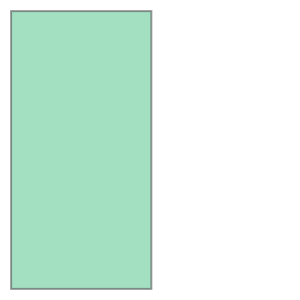

                                            geometry
0  POLYGON ((503915.000 5495031.000, 503915.000 5...


[{'type': 'Polygon',
  'coordinates': [[[503915.0, 5495031.0],
    [503915.0, 5472527.0],
    [492554.0, 5472527.0],
    [492554.0, 5495031.0],
    [503915.0, 5495031.0]]]}]

Masking bare earth to bounding box...
Masking STM to bounding box...
Subtracting raster arrays...
[[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]


(22504, 11361)

(22504, 11361)

subtracting....
updating meta date - dimensions...
writing snow depth raster to file:VAN_P05_sd_raw.tif
Snow depth raster created..


(<open DatasetReader name='H:/Metro-Van/2021/DEM/Baseline_Master_Dataset_WGS84/VAN_snowfree_merged_wgs84_utm10_itrf08_epoch2002_dz20cm_1mDEM.tif' mode='r'>,
 <open DatasetReader name='H:/Metro-Van/2021/DEM/Coreg_STM/VAN_P05_coregSTM.tif' mode='r'>)

In [27]:
file_loop(multiple,phase_list, STM)

In [ ]:
#print(BE.shape)

In [ ]:
# def subtract_rasters (BE,BE_meta, STM, outdirectory, wshed, phase):
#         BE = src.read(1, masked=True).squeeze()
        
#         display(BE)
#     with rio.open(STM) as src:
#         STM = src.read(1, masked=True).squeeze()
#     SD = STM - BE
#     os.chdir(outdirectory)
#     outname = wshed + "_" + phase + "_sd_raw.csv"
#     with rio.open(out_name, "w", **meta) as dst:
#     dst.write(SD, 1)
    

In [ ]:

# display(BE)
# STM = STM.read(1, masked=True)
# display(STM)

In [ ]:
# with rio.open(STM) as src:
#     STM = src.read(1)
#     STM_meta = src.meta
#     STM_crs = src.meta
#     display(STM)

In [ ]:
# display(STM.shape==BE.shape)

#else will call function

In [ ]:
# display(STM.bounds)